In [33]:
import numpy as np
import pandas as pd
import statistics as st
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA, KernelPCA

In [28]:
def calculate_RMSE(value, predicted_value):
    distance = (value - predicted_value)**2
    length = len(value)
    RMSE = (distance.sum()/length)**0.5
    return RMSE

In [29]:
def calculate_R_sq_adj(R_sq, N, p):
    R_sq_adj = 1 - (1-R_sq) * (N-1)/(N-p-1)
    return R_sq_adj

In [50]:
def analysis(value, predicted_value, N, p, prefix = ""):
    if len(prefix) > 0:
        prefix = prefix + "_"
    RMSE = calculate_RMSE(value, predicted_value)
    R_sq = r2_score(value, predicted_value)
    R_sq_adj = calculate_R_sq_adj(R_sq, N, p)
    print(prefix + "RMSE:" + f"{RMSE}", 
          prefix + "R_sq:" + f"{R_sq}", 
          prefix + "R_sq_adj:" + f"{R_sq_adj}", 
          sep = "\n")
    return

### Import data and create dataframe

In [11]:
characteristics = pd.read_csv("data_folder/train.csv")
elements = pd.read_csv("data_folder/unique_m.csv")
elements = elements[elements.columns.difference(["critical_temp", "material"])]
frame = characteristics.join(elements)

### Split frame into train and test datasets

In [23]:
train, test = train_test_split(frame, test_size=0.3, random_state = 25)
train_y = train["critical_temp"]
train_without_y = train[train.columns.difference(["critical_temp"])]
test_y = test["critical_temp"]
test_without_y = test[test.columns.difference(["critical_temp"])]

### Standartize the data

In [42]:
scale = StandardScaler()
scale.fit(train_without_y)

train_without_y_scaled = scale.transform(train_without_y)
test_without_y_scaled = scale.transform(test_without_y)

train_without_y_scaled = pd.DataFrame(train_without_y_scaled, index = train_without_y.index,
                                     columns = train_without_y.columns)
test_without_y_scaled = pd.DataFrame(test_without_y_scaled, index = test_without_y.index,
                                     columns = test_without_y.columns)

### Perform linear Regeression

In [45]:
model = LinearRegression()
model.fit(train_without_y_scaled, train_y)

LinearRegression()

### Predict the values

In [47]:
train_y_pred = model.predict(train_without_y_scaled)
test_y_pred = model.predict(test_without_y_scaled)

### Estimate RMSE, R_sq and R_sq_adjusted for train

In [51]:
analysis(train_y, train_y_pred, len(train_y), 
         len(train_without_y_scaled.columns), 
         prefix = "train")

train_RMSE:16.64092403015333
train_R_sq:0.7645985917176017
train_R_sq_adj:0.7619272112349189


### Estimate RMSE, R_sq and R_sq_adjusted for test

In [52]:
analysis(test_y, test_y_pred, len(test_y), 
         len(test_without_y_scaled.columns), 
         prefix = "test")

test_RMSE:16.6964340770611
test_R_sq:0.7609440797717777
test_R_sq_adj:0.7545163968417965


### Perform PCA

In [161]:
pca = PCA(n_components=train_without_y_scaled.shape[1], random_state=25)
pca.fit(train_without_y_scaled)

PCA(n_components=167, random_state=25)

### Search for optimal number of pricipal components

In [176]:
number = np.arange(1,168)
explained_variance = pca.explained_variance_
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

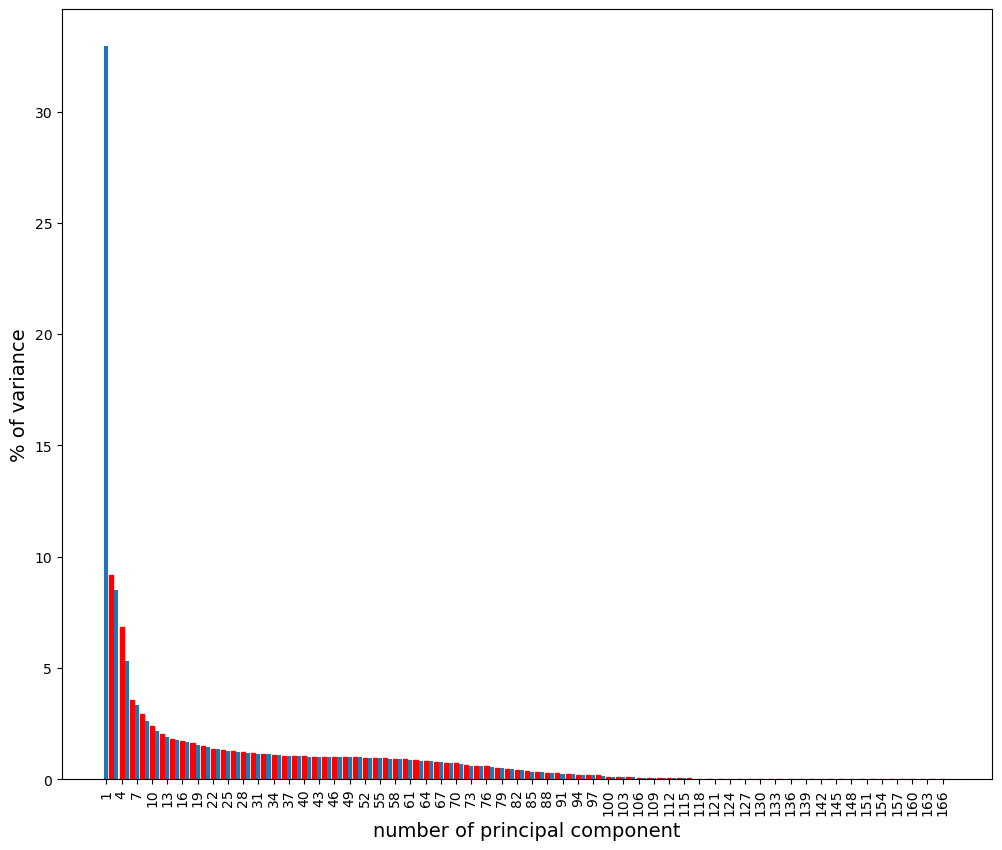

In [169]:
plt.figure(figsize=(12,10))
bars = plt.bar(number, explained_variance)
for i in range(1,166,2):
    bars[i].set_color("r")
plt.xticks(np.arange(1,167,3), rotation = "vertical")
plt.xlabel("number of principal component", fontsize = 14)
plt.ylabel("% of variance", fontsize = 14)
plt.show()

In [81]:
PC_crit = np.min(np.where((cumulative_variane >= 0.95) & (cumulative_variane < 0.96)))

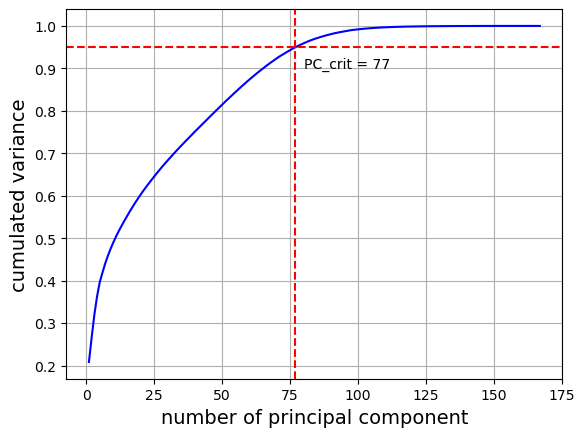

In [177]:
plt.plot(number, cumulative_variance, color = "blue")
plt.axhline(0.95, ls = "--", color = "red")
plt.axvline(PC_crit, ls = "--", color = "red")
plt.grid()
plt.xlabel("number of principal component", fontsize = 14)
plt.ylabel("cumulated variance", fontsize = 14)
plt.text(80, 0.9, f"PC_crit = {PC_crit}", fontsize=10);
plt.show()

Number of principal components is set as 77

In [96]:
pca = PCA(n_components=77, random_state=25)
pca.fit(train_without_y_scaled)

PCA(n_components=77, random_state=25)

### Transform the data

In [107]:
pca_train = pca.transform(train_without_y_scaled)
pca_test = pca.transform(test_without_y_scaled)
columns_names = [f"PC{i}" for i in range(1,78)]
pca_train = pd.DataFrame(pca_train, columns = columns_names)
pca_test = pd.DataFrame(pca_test, columns = columns_names)

### Perform linear regression 

In [99]:
model_2 = LinearRegression()
model_2.fit(pca_train, train_y)

LinearRegression()

### Predict the values

In [100]:
pca_train_y_pred = model_2.predict(pca_train)
pca_test_y_pred = model_2.predict(pca_test)

### Estimate RMSE, R_sq and R_sq_adjusted for pca_train

In [108]:
analysis(train_y, pca_train_y_pred, len(train_y), 
         len(pca_train.columns), 
         prefix = "pca_train")

pca_train_RMSE:19.79503190214487
pca_train_R_sq:0.6669061664686498
pca_train_R_sq_adj:0.6651738805587541


### Estimate RMSE, R_sq and R_sq_adjusted for pca_test

In [109]:
analysis(test_y, pca_test_y_pred, len(test_y), 
         len(pca_test.columns), 
         prefix = "pca_test")

pca_test_RMSE:19.361799969369184
pca_test_R_sq:0.6785277370412153
pca_test_R_sq_adj:0.6745992551736028


Model based on standart PCA is worse than even basic linear regression

### Perform kernel PCA

In [110]:
kpca = KernelPCA(kernel = "rbf", n_components=train_without_y_scaled.shape[1], random_state=25)
kpca.fit(train_without_y_scaled)

KernelPCA(kernel='rbf', n_components=167, random_state=25)

### Search for optimal number of pricipal components

In [112]:
kpca_transform = kpca.transform(train_without_y_scaled)

In [200]:
kernel_explained_variance = np.var(kpca_transform, axis=0)
kernel_explained_variance_ratio = kernel_explained_variance / np.sum(kernel_explained_variance)
kernel_cumulative_variance = np.cumsum(kernel_explained_variance_ratio)

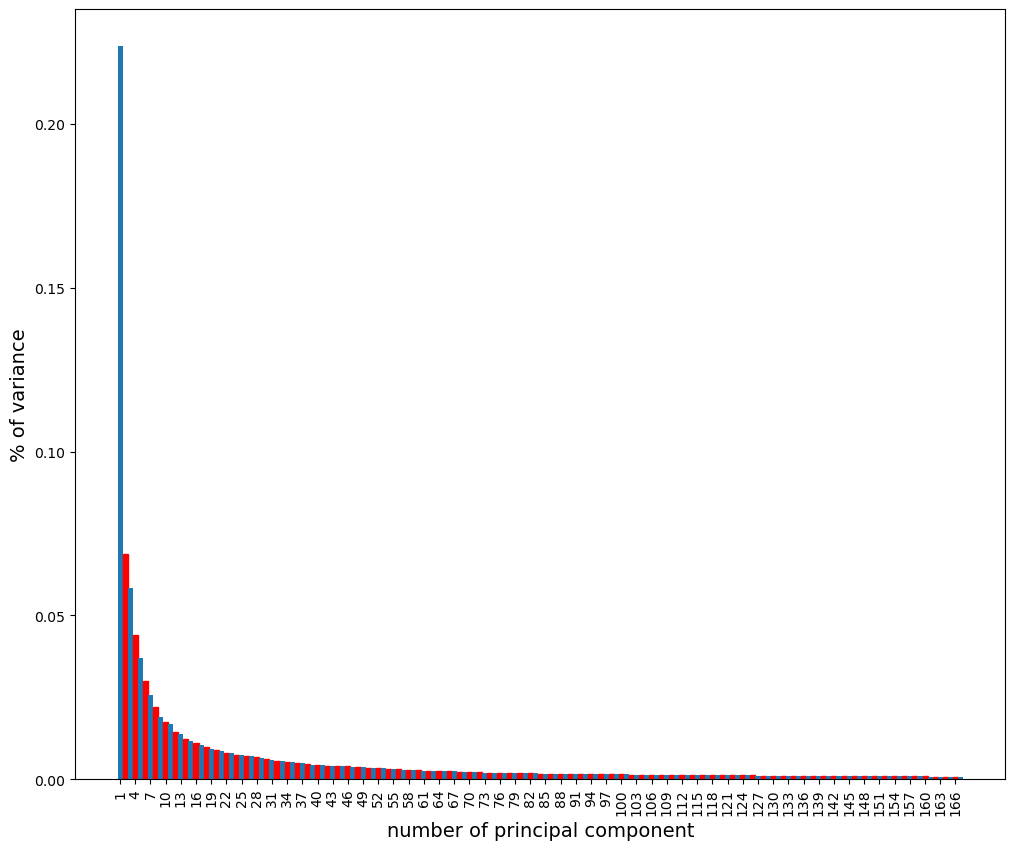

In [201]:
plt.figure(figsize=(12,10))
bars = plt.bar(number, kernel_explained_variance_ratio, width=1)
for i in range(1,166,2):
    bars[i].set_color('r')
plt.xticks(np.arange(1,167,3), rotation = "vertical")
plt.xlabel("number of principal component", fontsize = 14)
plt.ylabel("% of variance", fontsize = 14)
plt.show()

In [205]:
kernel_PC_crit = np.min(np.where((kernel_cumulative_variance >= 0.95) & (kernel_cumulative_variance < 0.96)))

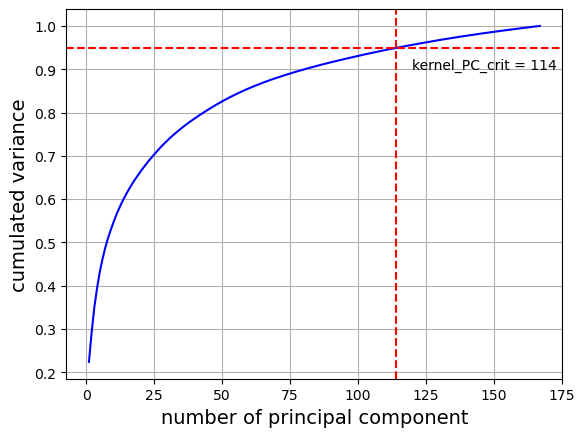

In [209]:
plt.plot(number, kernel_cumulative_variance, color = "blue")
plt.axhline(0.95, ls = "--", color = "red")
plt.axvline(kernel_PC_crit, ls = "--", color = "red")
plt.grid()
plt.xlabel("number of principal component", fontsize = 14)
plt.ylabel("cumulated variance", fontsize = 14)
plt.text(120, 0.9, f"kernel_PC_crit = {kernel_PC_crit}", fontsize=10);
plt.show()

Number of principal components is set as 114

In [210]:
kpca = KernelPCA(kernel = "rbf", n_components=114, random_state=25)
kpca.fit(train_without_y_scaled)

KernelPCA(kernel='rbf', n_components=114, random_state=25)

### Transform the data

In [211]:
kernal_pca_train = kpca.transform(train_without_y_scaled)
kernal_pca_test = kpca.transform(test_without_y_scaled)
columns_names = [f"PC{i}" for i in range(1,115)]
kernal_pca_train = pd.DataFrame(kernal_pca_train, columns = columns_names)
kernal_pca_test = pd.DataFrame(kernal_pca_test, columns = columns_names)

### Perform linear regression

In [212]:
model_3 = LinearRegression()
model_3.fit(kernal_pca_train, train_y)

LinearRegression()

### Predict the values

In [214]:
kernal_pca_train_y_pred = model_3.predict(kernal_pca_train)
kernal_pca_test_y_pred = model_3.predict(kernal_pca_test)

### Estimate RMSE, R_sq and R_sq_adjusted for kernal_pca_train

In [216]:
analysis(train_y, kernal_pca_train_y_pred, len(train_y), 
         len(kernal_pca_train.columns), 
         prefix = "kernal_pca_train")

kernal_pca_train_RMSE:15.632017108765918
kernal_pca_train_R_sq:0.792277173147912
kernal_pca_train_R_sq_adj:0.7906737875252471


### Estimate RMSE, R_sq and R_sq_adjusted for kernal_pca_test

In [217]:
analysis(test_y, kernal_pca_test_y_pred, len(train_y), 
         len(kernal_pca_test.columns), 
         prefix = "kernal_pca_test")

kernal_pca_test_RMSE:15.671285394492116
kernal_pca_test_R_sq:0.7893985830523063
kernal_pca_test_R_sq_adj:0.7877729779651618


Model on the base of kernel pca is more accurate than basic linear regression model